# CIFAR 100 - Keras

In [1]:
# Import all modules
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
#from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-100 datasets
from keras.datasets import cifar100

Using TensorFlow backend.


In [2]:
#Load the Dataset 
(x_train, y_train), (x_test,y_test) = cifar100.load_data()

class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

169009152/169001437 [==============================] - 5s 0us/step


In [3]:
#Declaring Variables
batch_size = 32 #32 #Smaller Batch size means more updates in one epoch

num_classes = 100 
epochs = 200#100 #Repeat 100 times

# Looking at the dataset

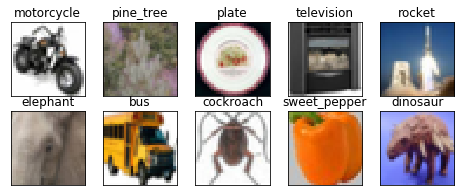

In [4]:
# Print 10 random images for 10 random classes 
fig = plt.figure(figsize=(8,3))
for i in range(10):
    num = np.random.randint(100)
    ax = fig.add_subplot(2,5,1 + i, xticks=[],yticks=[])
    idx = np.where(y_train[:]== num)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
    ax.set_title(class_names[num])
    plt.imshow(im)
plt.show()

# Data Augmentation

In [5]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(x_train)

Looking at the images generated using the flow method. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


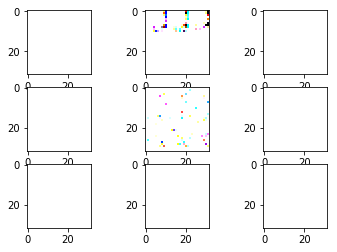

In [6]:
from matplotlib import pyplot as plt
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(32, 32, 3))
        #plt.imshow(toimage(X_batch[i].reshape(32, 32, 3))) 
    # show the plot
    plt.show()
    break

# Data Regularisation
We now need to normalize the pixel values. This means to turn them from in the range of 0-255 to be between 0 and 1. 

In [7]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# Making a model

In [8]:
#Architecture from: https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/
import keras
from keras import regularizers
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

def model():
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    return model
cnn = model() 
cnn.summary()
 
# Fit model
cnn4 = cnn.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
#cnn4 = cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
__________

1562/1562 [==============================] - 59s 38ms/step - loss: 3.2723 - acc: 0.3456 - val_loss: 3.0171 - val_acc: 0.4014
Epoch 26/125
1562/1562 [==============================] - 58s 37ms/step - loss: 3.2631 - acc: 0.3484 - val_loss: 3.0614 - val_acc: 0.3913
Epoch 27/125
1562/1562 [==============================] - 57s 36ms/step - loss: 3.2630 - acc: 0.3505 - val_loss: 3.0569 - val_acc: 0.3986
Epoch 28/125
1562/1562 [==============================] - 63s 40ms/step - loss: 3.2532 - acc: 0.3560 - val_loss: 2.9790 - val_acc: 0.4180
Epoch 29/125
1562/1562 [==============================] - 64s 41ms/step - loss: 3.2422 - acc: 0.3610 - val_loss: 3.1784 - val_acc: 0.3737
Epoch 30/125
1562/1562 [==============================] - 63s 40ms/step - loss: 3.2287 - acc: 0.3655 - val_loss: 3.0073 - val_acc: 0.4184
Epoch 31/125
1562/1562 [==============================] - 63s 40ms/step - loss: 3.2200 - acc: 0.3683 - val_loss: 3.0994 - val_acc: 0.3973
Epoch 32/125
1562/1562 [=======================

1562/1562 [==============================] - 60s 38ms/step - loss: 2.7232 - acc: 0.4713 - val_loss: 2.6059 - val_acc: 0.4987
Epoch 85/125
1562/1562 [==============================] - 58s 37ms/step - loss: 2.7177 - acc: 0.4708 - val_loss: 2.6807 - val_acc: 0.4860
Epoch 86/125
1562/1562 [==============================] - 58s 37ms/step - loss: 2.7088 - acc: 0.4738 - val_loss: 2.5908 - val_acc: 0.5054
Epoch 87/125
1562/1562 [==============================] - 58s 37ms/step - loss: 2.7060 - acc: 0.4732 - val_loss: 2.6031 - val_acc: 0.4950
Epoch 88/125
1562/1562 [==============================] - 57s 36ms/step - loss: 2.6999 - acc: 0.4723 - val_loss: 2.6509 - val_acc: 0.4867
Epoch 89/125
1562/1562 [==============================] - 56s 36ms/step - loss: 2.6920 - acc: 0.4745 - val_loss: 2.5866 - val_acc: 0.5041
Epoch 90/125
1562/1562 [==============================] - 56s 36ms/step - loss: 2.6980 - acc: 0.4729 - val_loss: 2.5754 - val_acc: 0.5046
Epoch 91/125
1562/1562 [=======================

# Plotting our accuracy and loss
Looking at the last epoch, we have 72% accuracy in the training set but 57% in our validation, so it looks like the model is overfitting. 

In [9]:
scores = cnn.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 52.28%


[]

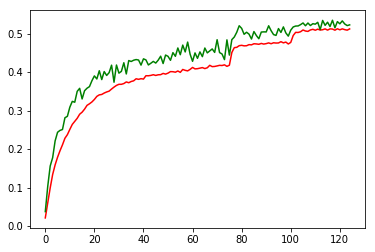

In [10]:
plt.figure(0)
plt.plot(cnn4.history['acc'],'r')
plt.plot(cnn4.history['val_acc'],'g')
plt.plot()

# Confusion Matrix for our model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)
 
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd

df_cm = pd.DataFrame(cm, range(100),range(100))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

# Saving our model to disk

In [ ]:
#save to disk
model_json = cnn.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
cnn.save_weights('model.h5') 

# Using our model for prediction. 

In [ ]:
from matplotlib import pyplot
from scipy.misc import toimage
from keras.models import model_from_json

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
# mean-std normalization
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
    
show_imgs(x_test[:16])
 
# Load trained CNN model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('model.h5')
 
labels = class_names
 
indices = np.argmax(model.predict(x_test[:16]),1)
print([labels[x] for x in indices])

You can see it gets some of them correct, like the lamp and rocket, but it predicts the lion to be a bee and other mistakes. 